<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/model-classification/Classify_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [36]:
from google.colab import files
uploaded = files.upload()

Saving ZM_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv to ZM_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns (3).csv
Saving Z_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv to Z_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns (3).csv
Saving Y_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv to Y_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns (3).csv
Saving XPEV_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv to XPEV_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns (3).csv
Saving XOM_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv to XOM_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns (3).csv
Saving X_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv to X_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns (3).csv
Saving WMT_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv to WMT_2000-01-01 00_00_00_2021-06-04_30_double_to

## Import packages

In [37]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from scipy import stats

## Get data at pattern for training & testing

In [38]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
for filename in uploaded.keys():
    print(filename)
    if 'double_top_data_patterns.csv' not in filename:
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    try:
        df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
                        header=None)
        price_patterns_df = price_patterns_df.append(df)
    except:
        print('Error', filename)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

ZM_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
Z_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
Y_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
XPEV_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
XOM_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
X_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
WMT_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
WFC_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
W_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
VZ_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
VXRT_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
VICI_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
VIAC_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
V_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
TSLA_2000-01-01 00_00_00_2021-06-04_30_double_top_data_patterns.csv
T_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,42.340000,42.889999,42.630001,42.759998,43.000000,43.849998,43.459999,43.230000,42.849998,42.439999,42.810001,44.320000,43.389999,42.610001,41.349998,40.959999,41.560001,41.900002,42.080002,40.990002,41.849998,42.320000,42.099998,41.669998,42.110001,43.730000,44.849998,43.939999,44.520000,43.450001,42.040001
1,11178.445312,11119.090820,11109.198242,11138.875977,11307.046875,11346.617188,11346.617188,11218.015625,10950.919922,10950.919922,10950.919922,10861.887695,11099.305664,11138.875977,11376.293945,11564.250000,11316.939453,11682.958984,11504.895508,11326.832031,11267.477539,11069.628906,11089.414062,11218.015625,11247.692383,11336.724609,11148.768555,11307.046875,11247.692383,10980.596680,10683.824219
2,256.799988,248.559998,253.539993,259.130005,261.739990,261.000000,262.100006,266.320007,269.519989,275.869995,260.299988,260.010010,256.220001,248.539993,246.539993,268.579987,260.440002,261.179993,251.500000,246.559998,252.330002,252.179993,252.389999,250.000000,253.910004,268.000000,267.339996,272.899994,268.250000,258.730011,250.000000
3,99.019997,99.860001,98.639999,99.500000,100.250000,101.129997,103.320000,105.980003,96.639999,99.339996,103.290001,102.930000,104.480003,104.500000,103.459999,103.129997,107.400002,108.139999,109.089996,107.769997,108.129997,109.059998,109.849998,109.330002,108.559998,109.419998,110.000000,110.349998,109.500000,108.400002,108.930000
4,23.360001,22.480000,22.379999,22.750000,25.559999,25.809999,26.250000,27.010000,26.010000,24.709999,25.100000,23.520000,23.950001,24.730000,25.330000,24.840000,25.000000,26.709999,27.480000,25.600000,26.850000,26.190001,26.059999,26.570000,26.730000,26.760000,27.459999,27.879999,27.959999,25.200001,25.719999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6896,38.709999,38.990002,39.029999,39.060001,39.360001,39.520000,39.779999,39.680000,39.389999,39.470001,39.500000,39.910000,40.750000,40.529999,40.680000,40.279999,40.430000,39.930000,39.660000,39.759998,39.340000,39.439999,40.919998,40.500000,40.259998,40.360001,40.759998,40.330002,40.470001,40.060001,40.709999
6897,117.230003,119.970001,119.809998,117.209999,120.330002,119.180000,117.250000,115.989998,117.320000,118.370003,118.430000,119.680000,119.480003,119.820000,120.739998,120.760002,120.940002,119.430000,117.660004,117.290001,117.720001,118.410004,121.570000,121.739998,123.309998,123.610001,125.400002,123.650002,124.550003,123.000000,123.650002
6898,195.000000,195.000000,172.500000,172.500000,180.000000,187.500000,187.500000,195.000000,195.000000,247.500000,225.000000,225.000000,195.000000,202.500000,210.000000,217.500000,225.000000,210.000000,195.000000,202.500000,187.500000,217.500000,210.000000,210.000000,195.000000,187.500000,210.000000,202.500000,217.500000,202.500000,217.500000
6899,53.500000,54.849998,55.020000,55.139999,55.580002,53.630001,53.520000,52.779999,53.240002,55.200001,55.619999,55.150002,55.090000,54.560001,54.430000,55.669998,54.730000,54.119999,55.980000,54.900002,54.020000,54.549999,54.750000,55.299999,54.599998,55.400002,55.250000,54.700001,55.950001,53.200001,53.099998


In [39]:
#@title Separate into input and output columns: Get data: X and y
pre_time_steps = 30 #@param {type:"integer"}

X_df = price_patterns_df[price_patterns_df.columns[-(pre_time_steps + 1):-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

                0             1   ...            28            29
0        42.340000     42.889999  ...     44.520000     43.450001
1     11178.445312  11119.090820  ...  11247.692383  10980.596680
2       256.799988    248.559998  ...    268.250000    258.730011
3        99.019997     99.860001  ...    109.500000    108.400002
4        23.360001     22.480000  ...     27.959999     25.200001
...            ...           ...  ...           ...           ...
6896     38.709999     38.990002  ...     40.470001     40.060001
6897    117.230003    119.970001  ...    124.550003    123.000000
6898    195.000000    195.000000  ...    217.500000    202.500000
6899     53.500000     54.849998  ...     55.950001     53.200001
6900   2958.000000   2988.000000  ...   3612.000000   3576.000000

[6901 rows x 30 columns]
                30
0        42.040001
1     10683.824219
2       250.000000
3       108.930000
4        25.719999
...            ...
6896     40.709999
6897    123.650002
6898    217

In [46]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

def get_binary_direction(pre, cur, min_change=0):
    d = get_direction(pre, cur, min_change)
    if d < 1:
        d = 0
    return d

def y_preice_to_y_label(X, y, min_change=0, num_classes=2):
    assert len(X) == len(y)
    n = len(y)
    if num_classes == 2:
        y_label = np.array([get_binary_direction(X[i][-1], y[i], min_change) for i in range(n)])
    else:
        y_label = np.array([get_direction(X[i][-1], y[i], min_change) for i in range(n)])
        # Convert from {-1; 0; 1} to label {0; 1; 2}
        y_label = y_label + 1
    return y_label

In [57]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]
min_price_change = 0 #@param {type:"number"}
num_classes = 2 #@param {type:"integer"}

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=train_ratio, random_state=7)
X_train, y_train = X_data[: n_train], y_data[: n_train]
X_test, y_test = X_data[n_train:], y_data[n_train:]
y_train_label = y_preice_to_y_label(X_train, y_train, min_price_change, num_classes=num_classes)
y_train_categorical = to_categorical(y_train_label, num_classes=num_classes)
y_test_label = y_preice_to_y_label(X_test, y_test, min_price_change, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_label, num_classes=num_classes)
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    y_train_scaled_label = y_preice_to_y_label(X_train_scaled, y_train_scaled, min_price_change, num_classes=num_classes)
    y_train_scaled_categorical = to_categorical(y_train_scaled_label, num_classes=num_classes)
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    y_test_scaled_label = y_preice_to_y_label(X_test_scaled, y_test_scaled, min_price_change, num_classes=num_classes)
    y_test_scaled_categorical = to_categorical(y_test_scaled_label, num_classes=num_classes)
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(y_train_categorical.shape)
print(y_train_scaled_categorical.shape)
print('Stats y_train:', stats.describe(y_train))
print('Stats y_train_scaled:', stats.describe(y_train_scaled))
print('Stats y_train_label:', stats.describe(y_train_label))
print(np.bincount(y_train_label))
print('Stats y_train_categorical:', stats.describe(y_train_categorical))
print('Stats y_train_scaled_label:', stats.describe(y_train_scaled_label))
print(np.bincount(y_train_scaled_label))
print('Stats y_train_scaled_categorical:', stats.describe(y_train_scaled_categorical))
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)
print(y_test_categorical.shape)
print(y_test_scaled_categorical.shape)

# print(X_train)
# print(y_train)
# print(y_train_label)
# print(y_train_categorical)

(5520, 30) (5520, 1)
(5520, 30) (5520, 1)
(5520, 2)
(5520, 2)
Stats y_train: DescribeResult(nobs=5520, minmax=(array([0.75999999]), array([2253825.])), mean=array([13704.50232168]), variance=array([8.89549561e+09]), skewness=array([14.79857766]), kurtosis=array([259.48203919]))
Stats y_train_scaled: DescribeResult(nobs=5520, minmax=(array([-2.07671961]), array([6.2962963])), mean=array([0.43354356]), variance=array([0.13196952]), skewness=array([0.50006861]), kurtosis=array([12.59908896]))
Stats y_train_label: DescribeResult(nobs=5520, minmax=(0, 1), mean=0.4971014492753623, variance=0.25003689494263565, skewness=0.011594397723085795, kurtosis=-1.9998655699414392)
[2776 2744]
Stats y_train_categorical: DescribeResult(nobs=5520, minmax=(array([0., 0.], dtype=float32), array([1., 1.], dtype=float32)), mean=array([0.5028986 , 0.49710146], dtype=float32), variance=array([0.25004208, 0.25004208], dtype=float32), skewness=array([-0.01159441,  0.01159438], dtype=float32), kurtosis=array([-1.9

## LSTM model

### Build model

In [58]:
#@title Build & fit model
lstm_units =  128#@param {type:"integer"}
dropout_prob = 0.2 #@param {type:"number"}
epochs = 5000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}
lr = 0.001 #@param {type:"number"}



### Train model

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 66        
_________________________________________________________________
activation_10 (Activation)   (None, 2)                 0         
Total params: 70,754
Trainable params: 70,754
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
1/1 [==============================] - 4s 4s/step - loss: 0.6935 - accuracy: 0.4967 - val_loss: 0.6933

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 2/5000
1/1 [==============================] - 0s 214ms/step - loss: 0.6931 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.5004

Epoch 00002: val_accuracy did not improve from 0.50109
Epoch 3/5000
1/1 [==============================] - 0s 207ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6933 - val_accuracy: 0.4931

Epoch 00003: val_accuracy did not improve from 0.50109
Epoch 4/5000
1/1 [==============================] - 0s 186ms/step - loss: 0.6928 - accuracy: 0.5168 - val_loss: 0.6933 - val_accuracy: 0.4931

Epoch 00004: val_accuracy did not improve from 0.50109
Epoch 5/5000
1/1 [==============================] - 0s 186ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6934 - val_accuracy: 0.4996

Epoch 00005: val_accuracy did not improve from 0.50109
Epoch 6/5000
1/1 [==============================] - 0s 230ms/step - loss: 0.6931 - accuracy: 0.5036 - val_loss: 0.6934 - val_accuracy: 0.4953

Epoch 00006: val_accuracy did not improve from 0.50109
Epoch 7/50

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 11/5000
1/1 [==============================] - 0s 185ms/step - loss: 0.6928 - accuracy: 0.5109 - val_loss: 0.6934 - val_accuracy: 0.5033

Epoch 00011: val_accuracy improved from 0.50181 to 0.50326, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc
INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 12/5000
1/1 [==============================] - 0s 187ms/step - loss: 0.6927 - accuracy: 0.5181 - val_loss: 0.6934 - val_accuracy: 0.4982

Epoch 00012: val_accuracy did not improve from 0.50326
Epoch 13/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6928 - accuracy: 0.5136 - val_loss: 0.6935 - val_accuracy: 0.5018

Epoch 00013: val_accuracy did not improve from 0.50326
Epoch 14/5000
1/1 [==============================] - 0s 183ms/step - loss: 0.6927 - accuracy: 0.5111 - val_loss: 0.6935 - val_accuracy: 0.4975

Epoch 00014: val_accuracy did not improve from 0.50326
Epoch 15/5000
1/1 [==============================] - 0s 187ms/step - loss: 0.6927 - accuracy: 0.5185 - val_loss: 0.6936 - val_accuracy: 0.4982

Epoch 00015: val_accuracy did not improve from 0.50326
Epoch 16/5000
1/1 [==============================] - 0s 186ms/step - loss: 0.6928 - accuracy: 0.5143 - val_loss: 0.6936 - val_accuracy: 0.4924

Epoch 00016: val_accuracy did not improve from 0.50326
Epoch

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 62/5000
1/1 [==============================] - 0s 193ms/step - loss: 0.6925 - accuracy: 0.5205 - val_loss: 0.6939 - val_accuracy: 0.4982

Epoch 00062: val_accuracy did not improve from 0.50543
Epoch 63/5000
1/1 [==============================] - 0s 191ms/step - loss: 0.6923 - accuracy: 0.5159 - val_loss: 0.6938 - val_accuracy: 0.4895

Epoch 00063: val_accuracy did not improve from 0.50543
Epoch 64/5000
1/1 [==============================] - 0s 192ms/step - loss: 0.6924 - accuracy: 0.5165 - val_loss: 0.6938 - val_accuracy: 0.4938

Epoch 00064: val_accuracy did not improve from 0.50543
Epoch 65/5000
1/1 [==============================] - 0s 185ms/step - loss: 0.6923 - accuracy: 0.5192 - val_loss: 0.6938 - val_accuracy: 0.4960

Epoch 00065: val_accuracy did not improve from 0.50543
Epoch 66/5000
1/1 [==============================] - 0s 185ms/step - loss: 0.6922 - accuracy: 0.5228 - val_loss: 0.6939 - val_accuracy: 0.5054

Epoch 00066: val_accuracy did not improve from 0.50543
Epoch

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 68/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6923 - accuracy: 0.5194 - val_loss: 0.6942 - val_accuracy: 0.5062

Epoch 00068: val_accuracy did not improve from 0.50905
Epoch 69/5000
1/1 [==============================] - 0s 185ms/step - loss: 0.6921 - accuracy: 0.5237 - val_loss: 0.6943 - val_accuracy: 0.5076

Epoch 00069: val_accuracy did not improve from 0.50905
Epoch 70/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6924 - accuracy: 0.5221 - val_loss: 0.6941 - val_accuracy: 0.5033

Epoch 00070: val_accuracy did not improve from 0.50905
Epoch 71/5000
1/1 [==============================] - 0s 188ms/step - loss: 0.6923 - accuracy: 0.5170 - val_loss: 0.6940 - val_accuracy: 0.5069

Epoch 00071: val_accuracy did not improve from 0.50905
Epoch 72/5000
1/1 [==============================] - 0s 180ms/step - loss: 0.6922 - accuracy: 0.5188 - val_loss: 0.6939 - val_accuracy: 0.5134

Epoch 00072: val_accuracy improved from 0.50905 to 0.51340, 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 73/5000
1/1 [==============================] - 0s 189ms/step - loss: 0.6921 - accuracy: 0.5194 - val_loss: 0.6938 - val_accuracy: 0.5047

Epoch 00073: val_accuracy did not improve from 0.51340
Epoch 74/5000
1/1 [==============================] - 0s 190ms/step - loss: 0.6920 - accuracy: 0.5245 - val_loss: 0.6939 - val_accuracy: 0.5018

Epoch 00074: val_accuracy did not improve from 0.51340
Epoch 75/5000
1/1 [==============================] - 0s 187ms/step - loss: 0.6921 - accuracy: 0.5149 - val_loss: 0.6939 - val_accuracy: 0.5018

Epoch 00075: val_accuracy did not improve from 0.51340
Epoch 76/5000
1/1 [==============================] - 0s 193ms/step - loss: 0.6921 - accuracy: 0.5170 - val_loss: 0.6939 - val_accuracy: 0.5004

Epoch 00076: val_accuracy did not improve from 0.51340
Epoch 77/5000
1/1 [==============================] - 0s 187ms/step - loss: 0.6919 - accuracy: 0.5196 - val_loss: 0.6938 - val_accuracy: 0.5054

Epoch 00077: val_accuracy did not improve from 0.51340
Epoch

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 428/5000
1/1 [==============================] - 0s 209ms/step - loss: 0.6865 - accuracy: 0.5319 - val_loss: 0.7000 - val_accuracy: 0.5134

Epoch 00428: val_accuracy did not improve from 0.51557
Epoch 429/5000
1/1 [==============================] - 0s 206ms/step - loss: 0.6862 - accuracy: 0.5388 - val_loss: 0.6955 - val_accuracy: 0.5112

Epoch 00429: val_accuracy did not improve from 0.51557
Epoch 430/5000
1/1 [==============================] - 0s 194ms/step - loss: 0.6854 - accuracy: 0.5335 - val_loss: 0.6949 - val_accuracy: 0.5141

Epoch 00430: val_accuracy did not improve from 0.51557
Epoch 431/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6857 - accuracy: 0.5391 - val_loss: 0.6952 - val_accuracy: 0.5127

Epoch 00431: val_accuracy did not improve from 0.51557
Epoch 432/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6853 - accuracy: 0.5389 - val_loss: 0.6988 - val_accuracy: 0.5177

Epoch 00432: val_accuracy improved from 0.51557 to 0.51

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 433/5000
1/1 [==============================] - 0s 185ms/step - loss: 0.6860 - accuracy: 0.5368 - val_loss: 0.6966 - val_accuracy: 0.5141

Epoch 00433: val_accuracy did not improve from 0.51774
Epoch 434/5000
1/1 [==============================] - 0s 182ms/step - loss: 0.6850 - accuracy: 0.5355 - val_loss: 0.6953 - val_accuracy: 0.5091

Epoch 00434: val_accuracy did not improve from 0.51774
Epoch 435/5000
1/1 [==============================] - 0s 183ms/step - loss: 0.6853 - accuracy: 0.5366 - val_loss: 0.6953 - val_accuracy: 0.5105

Epoch 00435: val_accuracy did not improve from 0.51774
Epoch 436/5000
1/1 [==============================] - 0s 194ms/step - loss: 0.6851 - accuracy: 0.5368 - val_loss: 0.6981 - val_accuracy: 0.5214

Epoch 00436: val_accuracy improved from 0.51774 to 0.52136, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc
INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 437/5000
1/1 [==============================] - 0s 186ms/step - loss: 0.6851 - accuracy: 0.5391 - val_loss: 0.6975 - val_accuracy: 0.5264

Epoch 00437: val_accuracy improved from 0.52136 to 0.52643, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc
INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 438/5000
1/1 [==============================] - 0s 182ms/step - loss: 0.6852 - accuracy: 0.5337 - val_loss: 0.6959 - val_accuracy: 0.5177

Epoch 00438: val_accuracy did not improve from 0.52643
Epoch 439/5000
1/1 [==============================] - 0s 194ms/step - loss: 0.6847 - accuracy: 0.5400 - val_loss: 0.6967 - val_accuracy: 0.5163

Epoch 00439: val_accuracy did not improve from 0.52643
Epoch 440/5000
1/1 [==============================] - 0s 186ms/step - loss: 0.6840 - accuracy: 0.5375 - val_loss: 0.6991 - val_accuracy: 0.5156

Epoch 00440: val_accuracy did not improve from 0.52643
Epoch 441/5000
1/1 [==============================] - 0s 189ms/step - loss: 0.6845 - accuracy: 0.5424 - val_loss: 0.6979 - val_accuracy: 0.5069

Epoch 00441: val_accuracy did not improve from 0.52643
Epoch 442/5000
1/1 [==============================] - 0s 191ms/step - loss: 0.6828 - accuracy: 0.5460 - val_loss: 0.6971 - val_accuracy: 0.5112

Epoch 00442: val_accuracy did not improve from 0.52643


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 475/5000
1/1 [==============================] - 0s 185ms/step - loss: 0.6833 - accuracy: 0.5400 - val_loss: 0.7060 - val_accuracy: 0.5228

Epoch 00475: val_accuracy did not improve from 0.52788
Epoch 476/5000
1/1 [==============================] - 0s 194ms/step - loss: 0.6820 - accuracy: 0.5424 - val_loss: 0.6997 - val_accuracy: 0.5127

Epoch 00476: val_accuracy did not improve from 0.52788
Epoch 477/5000
1/1 [==============================] - 0s 183ms/step - loss: 0.6822 - accuracy: 0.5458 - val_loss: 0.7025 - val_accuracy: 0.5192

Epoch 00477: val_accuracy did not improve from 0.52788
Epoch 478/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6833 - accuracy: 0.5395 - val_loss: 0.7158 - val_accuracy: 0.5322

Epoch 00478: val_accuracy improved from 0.52788 to 0.53222, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc
INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 479/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6815 - accuracy: 0.5462 - val_loss: 0.7115 - val_accuracy: 0.5235

Epoch 00479: val_accuracy did not improve from 0.53222
Epoch 480/5000
1/1 [==============================] - 0s 202ms/step - loss: 0.6805 - accuracy: 0.5516 - val_loss: 0.7037 - val_accuracy: 0.5192

Epoch 00480: val_accuracy did not improve from 0.53222
Epoch 481/5000
1/1 [==============================] - 0s 182ms/step - loss: 0.6805 - accuracy: 0.5444 - val_loss: 0.7062 - val_accuracy: 0.5163

Epoch 00481: val_accuracy did not improve from 0.53222
Epoch 482/5000
1/1 [==============================] - 0s 201ms/step - loss: 0.6811 - accuracy: 0.5464 - val_loss: 0.7133 - val_accuracy: 0.5228

Epoch 00482: val_accuracy did not improve from 0.53222
Epoch 483/5000
1/1 [==============================] - 0s 191ms/step - loss: 0.6803 - accuracy: 0.5464 - val_loss: 0.7079 - val_accuracy: 0.5025

Epoch 00483: val_accuracy did not improve from 0.53222


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 518/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6765 - accuracy: 0.5569 - val_loss: 0.7035 - val_accuracy: 0.5344

Epoch 00518: val_accuracy improved from 0.53295 to 0.53440, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc
INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 519/5000
1/1 [==============================] - 0s 189ms/step - loss: 0.6780 - accuracy: 0.5527 - val_loss: 0.6981 - val_accuracy: 0.5214

Epoch 00519: val_accuracy did not improve from 0.53440
Epoch 520/5000
1/1 [==============================] - 0s 182ms/step - loss: 0.6785 - accuracy: 0.5522 - val_loss: 0.6993 - val_accuracy: 0.5185

Epoch 00520: val_accuracy did not improve from 0.53440
Epoch 521/5000
1/1 [==============================] - 0s 188ms/step - loss: 0.6778 - accuracy: 0.5549 - val_loss: 0.7094 - val_accuracy: 0.5344

Epoch 00521: val_accuracy did not improve from 0.53440
Epoch 522/5000
1/1 [==============================] - 0s 191ms/step - loss: 0.6794 - accuracy: 0.5565 - val_loss: 0.6985 - val_accuracy: 0.5119

Epoch 00522: val_accuracy did not improve from 0.53440
Epoch 523/5000
1/1 [==============================] - 0s 187ms/step - loss: 0.6827 - accuracy: 0.5455 - val_loss: 0.6973 - val_accuracy: 0.5119

Epoch 00523: val_accuracy did not improve from 0.53440


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 539/5000
1/1 [==============================] - 0s 269ms/step - loss: 0.6756 - accuracy: 0.5556 - val_loss: 0.7077 - val_accuracy: 0.5170

Epoch 00539: val_accuracy did not improve from 0.53512
Epoch 540/5000
1/1 [==============================] - 0s 232ms/step - loss: 0.6760 - accuracy: 0.5558 - val_loss: 0.7004 - val_accuracy: 0.5177

Epoch 00540: val_accuracy did not improve from 0.53512
Epoch 541/5000
1/1 [==============================] - 0s 209ms/step - loss: 0.6775 - accuracy: 0.5551 - val_loss: 0.7073 - val_accuracy: 0.5301

Epoch 00541: val_accuracy did not improve from 0.53512
Epoch 542/5000
1/1 [==============================] - 0s 203ms/step - loss: 0.6747 - accuracy: 0.5601 - val_loss: 0.7191 - val_accuracy: 0.5337

Epoch 00542: val_accuracy did not improve from 0.53512
Epoch 543/5000
1/1 [==============================] - 0s 204ms/step - loss: 0.6782 - accuracy: 0.5480 - val_loss: 0.6982 - val_accuracy: 0.5192

Epoch 00543: val_accuracy did not improve from 0.53512


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 555/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6760 - accuracy: 0.5576 - val_loss: 0.6982 - val_accuracy: 0.5235

Epoch 00555: val_accuracy did not improve from 0.53729
Epoch 556/5000
1/1 [==============================] - 0s 192ms/step - loss: 0.6750 - accuracy: 0.5605 - val_loss: 0.6992 - val_accuracy: 0.5163

Epoch 00556: val_accuracy did not improve from 0.53729
Epoch 557/5000
1/1 [==============================] - 0s 200ms/step - loss: 0.6759 - accuracy: 0.5542 - val_loss: 0.7017 - val_accuracy: 0.5315

Epoch 00557: val_accuracy did not improve from 0.53729
Epoch 558/5000
1/1 [==============================] - 0s 209ms/step - loss: 0.6756 - accuracy: 0.5574 - val_loss: 0.7032 - val_accuracy: 0.5358

Epoch 00558: val_accuracy did not improve from 0.53729
Epoch 559/5000
1/1 [==============================] - 0s 184ms/step - loss: 0.6757 - accuracy: 0.5596 - val_loss: 0.7034 - val_accuracy: 0.5322

Epoch 00559: val_accuracy did not improve from 0.53729


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 612/5000
1/1 [==============================] - 0s 186ms/step - loss: 0.6807 - accuracy: 0.5496 - val_loss: 0.7054 - val_accuracy: 0.5279

Epoch 00612: val_accuracy did not improve from 0.54019
Epoch 613/5000
1/1 [==============================] - 0s 188ms/step - loss: 0.6763 - accuracy: 0.5600 - val_loss: 0.7031 - val_accuracy: 0.5185

Epoch 00613: val_accuracy did not improve from 0.54019
Epoch 614/5000
1/1 [==============================] - 0s 183ms/step - loss: 0.6801 - accuracy: 0.5556 - val_loss: 0.7026 - val_accuracy: 0.5286

Epoch 00614: val_accuracy did not improve from 0.54019
Epoch 615/5000
1/1 [==============================] - 0s 185ms/step - loss: 0.6731 - accuracy: 0.5585 - val_loss: 0.7164 - val_accuracy: 0.5141

Epoch 00615: val_accuracy did not improve from 0.54019
Epoch 616/5000
1/1 [==============================] - 0s 188ms/step - loss: 0.6828 - accuracy: 0.5467 - val_loss: 0.7061 - val_accuracy: 0.5257

Epoch 00616: val_accuracy did not improve from 0.54019


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 645/5000
1/1 [==============================] - 0s 186ms/step - loss: 0.6693 - accuracy: 0.5710 - val_loss: 0.7437 - val_accuracy: 0.5395

Epoch 00645: val_accuracy did not improve from 0.54308
Epoch 646/5000
1/1 [==============================] - 0s 193ms/step - loss: 0.6680 - accuracy: 0.5750 - val_loss: 0.7247 - val_accuracy: 0.5351

Epoch 00646: val_accuracy did not improve from 0.54308
Epoch 647/5000
1/1 [==============================] - 0s 196ms/step - loss: 0.6701 - accuracy: 0.5707 - val_loss: 0.7048 - val_accuracy: 0.5235

Epoch 00647: val_accuracy did not improve from 0.54308
Epoch 648/5000
1/1 [==============================] - 0s 186ms/step - loss: 0.6694 - accuracy: 0.5694 - val_loss: 0.7082 - val_accuracy: 0.5286

Epoch 00648: val_accuracy did not improve from 0.54308
Epoch 649/5000
1/1 [==============================] - 0s 187ms/step - loss: 0.6656 - accuracy: 0.5761 - val_loss: 0.7300 - val_accuracy: 0.5322

Epoch 00649: val_accuracy did not improve from 0.54308


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Epoch 685/5000
1/1 [==============================] - 0s 187ms/step - loss: 0.6696 - accuracy: 0.5659 - val_loss: 0.7382 - val_accuracy: 0.5329

Epoch 00685: val_accuracy did not improve from 0.54743
Epoch 686/5000
1/1 [==============================] - 0s 188ms/step - loss: 0.6676 - accuracy: 0.5681 - val_loss: 0.7427 - val_accuracy: 0.5402

Epoch 00686: val_accuracy did not improve from 0.54743
Epoch 687/5000
1/1 [==============================] - 0s 187ms/step - loss: 0.6676 - accuracy: 0.5717 - val_loss: 0.7339 - val_accuracy: 0.5351

Epoch 00687: val_accuracy did not improve from 0.54743
Epoch 688/5000
1/1 [==============================] - 0s 200ms/step - loss: 0.6655 - accuracy: 0.5797 - val_loss: 0.7198 - val_accuracy: 0.5402

Epoch 00688: val_accuracy did not improve from 0.54743
Epoch 689/5000
1/1 [==============================] - 0s 186ms/step - loss: 0.6663 - accuracy: 0.5725 - val_loss: 0.7301 - val_accuracy: 0.5380

Epoch 00689: val_accuracy did not improve from 0.54743


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc/assets


Streaming output truncated to the last 5000 lines.
Epoch 03751: val_accuracy did not improve from 0.55829
Epoch 3752/5000
1/1 [==============================] - 0s 213ms/step - loss: 0.5185 - accuracy: 0.7120 - val_loss: 1.6627 - val_accuracy: 0.5004

Epoch 03752: val_accuracy did not improve from 0.55829
Epoch 3753/5000
1/1 [==============================] - 0s 235ms/step - loss: 0.5154 - accuracy: 0.7170 - val_loss: 1.7554 - val_accuracy: 0.4946

Epoch 03753: val_accuracy did not improve from 0.55829
Epoch 3754/5000
1/1 [==============================] - 0s 197ms/step - loss: 0.5688 - accuracy: 0.6893 - val_loss: 1.7802 - val_accuracy: 0.4946

Epoch 03754: val_accuracy did not improve from 0.55829
Epoch 3755/5000
1/1 [==============================] - 0s 230ms/step - loss: 0.5159 - accuracy: 0.7170 - val_loss: 1.9741 - val_accuracy: 0.4859

Epoch 03755: val_accuracy did not improve from 0.55829
Epoch 3756/5000
1/1 [==============================] - 0s 221ms/step - loss: 0.5338 - accu

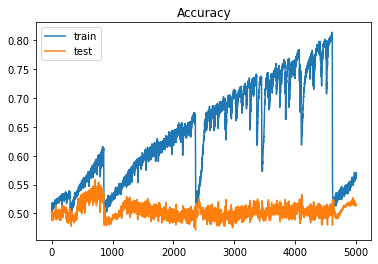

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


In [60]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units=50, dropout_prob=0.5, n_classes=2, epochs=6000, batch_size=32768, lr=0.001):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], n_classes))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], n_classes))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                   # return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   activation='relu'))
    model.add(Dropout(dropout_prob))
    # # Adding a second LSTM layer and some Dropout regularisation
    # model.add(LSTM(units=lstm_units,
    #             return_sequences=True))
    # model.add(Dropout(dropout_prob))
    # # Adding a third LSTM layer and some Dropout regularisation
    # model.add(LSTM(units=lstm_units,
    #             return_sequences=True))
    # model.add(Dropout(dropout_prob))
    # # Adding a fourth LSTM layer and some Dropout regularisation
    # model.add(LSTM(units=lstm_units))
    # model.add(Dropout(dropout_prob))
    # Adding the output layer
    # model.add(Dense(units=1))
    model.add(Dense(32, activation='relu'))
    # model.add(Dense(n_classes, activation='softmax'))
    model.add(Dense(n_classes))
    if n_classes == 2:
        model.add(Activation('sigmoid'))
    else:
        model.add(Activation('softmax'))

    # Adam optimizer
    opt = Adam(learning_rate=lr)

    checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc",
                                 monitor='val_accuracy', verbose=2,
                                 save_best_only=True, mode='auto')

    # Compiling the RNN
    # model.compile(optimizer = opt, loss = 'mean_squared_error')
    # model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if n_classes == 2:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()

    # Fitting the RNN to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        shuffle=False,
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[checkpoint])

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train)
    _, test_acc = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    # plot loss during training
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

    return model

# model = train_lstm(X_train, y_train_categorical,
#                    X_test, y_test_categorical,
#                    lstm_units=lstm_units, dropout_prob=dropout_prob, n_classes=num_classes,
#                    epochs=epochs, batch_size=batch_size, lr=lr)
model = train_lstm(X_train_scaled, y_train_scaled_categorical,
                   X_test_scaled, y_test_scaled_categorical,
                   lstm_units=lstm_units, dropout_prob=dropout_prob, n_classes=num_classes,
                   epochs=epochs, batch_size=batch_size, lr=lr)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest')

### Test model

In [61]:
def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [62]:
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_acc")

In [71]:
# y_pred = lstm_model.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
y_pred = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))

In [72]:
y_test_scaled_categorical, y_pred

(array([[0., 1.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]], dtype=float32), array([[0.49948263, 0.5107165 ],
        [0.41406503, 0.57762533],
        [0.50004953, 0.5117473 ],
        ...,
        [0.4729133 , 0.52918935],
        [0.44549006, 0.5561306 ],
        [0.5200995 , 0.48245943]], dtype=float32))

confusion_matrix: [[334 352]
 [258 437]]
acc: 0.558291093410572
              precision    recall  f1-score   support

           0       0.56      0.49      0.52       686
           1       0.55      0.63      0.59       695

    accuracy                           0.56      1381
   macro avg       0.56      0.56      0.56      1381
weighted avg       0.56      0.56      0.56      1381

confusion_matrix: [[1447 1329]
 [ 956 1788]]
acc: 0.5860507246376812
              precision    recall  f1-score   support

           0       0.60      0.52      0.56      2776
           1       0.57      0.65      0.61      2744

    accuracy                           0.59      5520
   macro avg       0.59      0.59      0.58      5520
weighted avg       0.59      0.59      0.58      5520



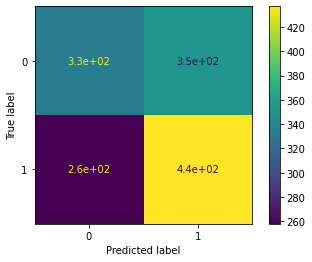

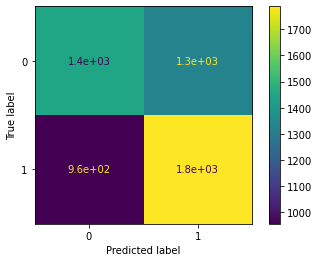

In [78]:
def show_val_res_label(y_true_label, y_pred_label):
    # y_true_label = y_true_label - 1
    # y_pred_label = y_pred_label - 1
    labels = list(range(np.min(y_true_label), np.max(y_true_label) + 1))
    cm = confusion_matrix(y_true_label, y_pred_label, labels=labels)
    print('confusion_matrix:', cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot()

    acc = accuracy_score(y_true_label, y_pred_label)
    print('acc:', acc)

    print(classification_report(y_true_label, y_pred_label))

def show_val_res_categorical(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)
    y_pred_label = np.argmax(y_pred, axis=1)
    show_val_res_label(y_true_label, y_pred_label)

# show_val_res_categorical(y_test_categorical, y_pred)
# show_val_res_categorical(y_train_categorical, lstm_model.predict(np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))))
show_val_res_categorical(y_test_scaled_categorical, y_pred)
show_val_res_categorical(y_train_scaled_categorical, lstm_model.predict(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))))

## XGBoost model

### Build model

In [66]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBClassifier

# xgbmodel = XGBClassifier(seed=seed,
#                         n_estimators=n_estimators,
#                         max_depth=max_depth,
#                         learning_rate=learning_rate,
#                         min_child_weight=min_child_weight,
#                         subsample=subsample,
#                         colsample_bytree=colsample_bytree,
#                         colsample_bylevel=colsample_bylevel,
#                         gamma=gamma)
xgbmodel = XGBClassifier()

### Train the model

In [67]:
# xgbmodel.fit(X_train, y_train_label)
xgbmodel.fit(X_train_scaled, y_train_scaled_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Test model

In [79]:
# y_pred = xgbmodel.predict(X_test)
y_pred = xgbmodel.predict(X_test_scaled)

confusion_matrix: [[355 331]
 [358 337]]
acc: 0.501086169442433
              precision    recall  f1-score   support

           0       0.50      0.52      0.51       686
           1       0.50      0.48      0.49       695

    accuracy                           0.50      1381
   macro avg       0.50      0.50      0.50      1381
weighted avg       0.50      0.50      0.50      1381



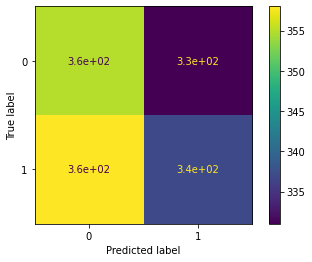

In [80]:
# show_val_res_label(y_test_label, y_pred)
show_val_res_label(y_test_scaled_label, y_pred)